In [1]:
import os
import base64
import joblib
import pandas as pd
import numpy as np
import category_encoders

import math

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, pairwise, precision_recall_curve, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def make_confmat_pretty(confmat):
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i,
                    s=confmat[i, j],
                    va='center', ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.title('Confusion Matrix')
    plt.show()
    
#Function to separate categorical and numerical features to insert in pipeline
def separate_cat_num_feat(df, columns_drop=None):
    if columns_drop:
        features = df.drop(columns=columns_drop).columns.tolist()
    else:
        features = df.columns.tolist()
    
    categorical_features = [i for i in features if df[i].dtype == 'object' or df[i].dtype == 'bool']
    numerical_features = [i for i in features if df[i].dtype == 'int64' or df[i].dtype == 'float']
    
    if len(features) != len(categorical_features) + len(numerical_features):
        print('Warning, there are missing categories in the separation procedure')
        print('Features length: {}, categorical_features length: {}, numerical_features length: {}'.format(len(features),
                                                                                                           len(categorical_features),
                                                                                                           len(numerical_features)))
        print(df.dtypes)
    return categorical_features, numerical_features

# Extracting Data

In [3]:
df_train = pd.read_csv("train.csv").set_index('id')
df_test = pd.read_csv("test.csv").set_index('id')
features = df_train.columns.to_list()
print(df_train.shape)
print(df_test.shape)

(223856, 19)
(95939, 19)


In [4]:
df_train.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Age,Race,Diabetic,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,External Heart Test Score,Weekly PhysicalActivity (H),HeartDisease
id,,,,,,,,,,,,,,,,,,,
392260,20.51,No,No,No,4.0,0.0,No,Female,48,White,No,NaN,8.0,No,No,No,-0.087426,9.0,0
240472,30.82,No,No,No,0.0,0.0,No,Female,71,Other,Yes,Very good,7.0,No,Yes,No,-0.243885,12.0,0
212573,33.91,No,No,No,0.0,0.0,No,Male,54,White,Yes,Good,6.0,No,No,No,-0.010218,1.0,0
233946,21.59,Yes,No,No,0.0,0.0,No,Male,84,White,No,Very good,8.0,No,No,No,-0.076278,11.0,0
427190,25.75,No,No,No,0.0,0.0,No,Female,77,White,No,Very good,7.0,Yes,No,No,-0.063184,10.0,0


# EDA

In [5]:
df_train.dtypes

BMI                            float64
Smoking                         object
AlcoholDrinking                 object
Stroke                          object
PhysicalHealth                 float64
MentalHealth                   float64
DiffWalking                     object
Sex                             object
Age                              int64
Race                            object
Diabetic                        object
GenHealth                       object
SleepTime                      float64
Asthma                          object
KidneyDisease                   object
SkinCancer                      object
External Heart Test Score      float64
Weekly PhysicalActivity (H)    float64
HeartDisease                     int64
dtype: object

In [6]:
df_train.nunique()

BMI                              3355
Smoking                             2
AlcoholDrinking                     2
Stroke                              2
PhysicalHealth                     31
MentalHealth                       31
DiffWalking                         2
Sex                                12
Age                                82
Race                                6
Diabetic                            4
GenHealth                           5
SleepTime                          27
Asthma                              2
KidneyDisease                       2
SkinCancer                          2
External Heart Test Score      223856
Weekly PhysicalActivity (H)        15
HeartDisease                        2
dtype: int64

In [7]:
df_train.isnull().sum()

BMI                                0
Smoking                            0
AlcoholDrinking                    0
Stroke                             0
PhysicalHealth                     0
MentalHealth                       0
DiffWalking                        0
Sex                             1900
Age                                0
Race                            4032
Diabetic                           0
GenHealth                      35000
SleepTime                       2024
Asthma                             0
KidneyDisease                      0
SkinCancer                      2205
External Heart Test Score          0
Weekly PhysicalActivity (H)        0
HeartDisease                       0
dtype: int64

In [8]:
df_train.describe()

,BMI,PhysicalHealth,MentalHealth,Age,SleepTime,External Heart Test Score,Weekly PhysicalActivity (H),HeartDisease
count,223856.000000,223856.000000,223856.000000,223856.000000,221832.000000,223856.000000,223856.000000,223856.000000
mean,28.330314,3.362152,3.899708,55.074244,7.096578,0.085433,6.857699,0.085247
std,6.360185,7.934836,7.958319,19.025598,1.440473,0.303383,4.651937,0.279249
min,12.020000,0.000000,0.000000,18.000000,-3.000000,-0.563692,0.000000,0.000000
25%,24.030000,0.000000,0.000000,40.000000,6.000000,-0.071873,2.000000,0.000000
50%,27.340000,0.000000,0.000000,57.000000,7.000000,0.014665,9.000000,0.000000
75%,31.450000,2.000000,3.000000,69.000000,8.000000,0.110031,11.000000,0.000000
max,93.970000,30.000000,30.000000,99.000000,48.000000,1.461253,14.000000,1.000000


In [9]:
df_train.duplicated().sum()

0

In [10]:
df_train.index.duplicated().sum()

0

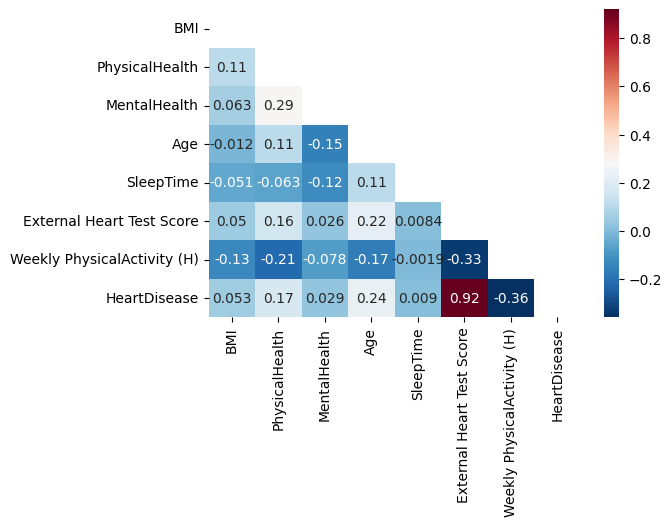

In [11]:
categorical_features, numerical_features = separate_cat_num_feat(df_train)

cor_mat = df_train[numerical_features].corr() 
lower_triangle_mask = np.triu(np.ones(cor_mat.shape)).astype(bool)
cor_mat_lower = cor_mat.mask(lower_triangle_mask)

plt.figure(figsize = (6,4)) 

sns.heatmap(cor_mat_lower, 
            annot=True, 
            cmap='RdBu_r');

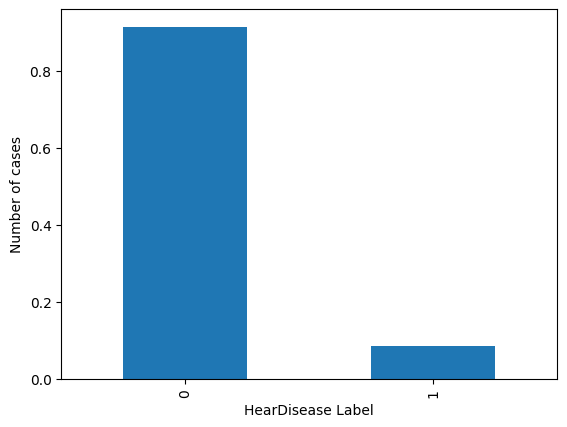

In [12]:
df_train.HeartDisease.value_counts(normalize=True).plot(kind="bar");
plt.xlabel('HearDisease Label');
plt.ylabel('Number of cases');

# Data Cleaning

In [13]:
def data_cleaner(df):
    df_ = df.copy()
    
    # Drop specific columns
    df_ = df_.drop(columns=['External Heart Test Score', 'Race', 'MentalHealth', 'Asthma'])
    
    # Fill missing values for 'GenHealth'
    df_['GenHealth'] = df_['GenHealth'].fillna('Excellent')
    
    # Drop duplicates and rows with any missing values
    df_ = df_.drop_duplicates()
    df_ = df_.dropna()
    
    # Clean 'Sex' column values and filter only 'Male' and 'Female'
    df_['Sex'] = df_['Sex'].replace({'M':'Male',
                          'm': 'Male',
                          'male': 'Male',
                          'F':'Female',
                          'f': 'Female',
                          'female': 'Female'
                        })
    df_ = df_[(df_['Sex'] == 'Male') | (df_['Sex'] == 'Female')]
    
    # Keep rows with valid 'SleepTime' values between 0 and 24
    df_ = df_[(df_['SleepTime'] >= 0) & (df_['SleepTime'] <= 24)]
    
    # Convert 'SleepTime' and 'BMI' columns to integer
    df_['SleepTime'] = df_['SleepTime'].astype(int)
    df_['BMI'] = df_['BMI'].astype(int)
    
    print('Nbr of obs: {}, ({}%)'.format(df_.shape[0], round(df_.shape[0]/df.shape[0]*100, 2)))
    return df_

df_train_clean = data_cleaner(df_train)
df_test_clean = data_cleaner(df_test)

Nbr of obs: 216757, (96.83%)
Nbr of obs: 95693, (99.74%)


# Feature Engineering

In [14]:
class CatPhysicalActiv(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X.loc[X['Weekly PhysicalActivity (H)'] == 0, 'PhysicalActivity'] = 'No'
        X.loc[X['Weekly PhysicalActivity (H)'] > 0, 'PhysicalActivity'] = 'Yes'
        
        return X 

In [15]:
class CatHealthyLifestyle(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X['HealthyLifestyle'] = 'No'
    
        X.loc[(X['PhysicalActivity'] == 'Yes') &
                (X['Smoking'] == 'No') &
                (X['AlcoholDrinking'] == 'No') &
                (X['Diabetic'] == 'No') &
                (X['SleepTime'] >= 6) &
                (X['BMI'] > 18) &
                (X['BMI'] < 30), 'HealthyLifestyle'] = 'Yes'
    
        return X 

# Creating the Model

216757
216757
297309
297309


/tmp/ipykernel_400/2593556377.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'No' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.loc[X['Weekly PhysicalActivity (H)'] == 0, 'PhysicalActivity'] = 'No'
/tmp/ipykernel_400/2593556377.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'No' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.loc[X['Weekly PhysicalActivity (H)'] == 0, 'PhysicalActivity'] = 'No'


General
ROCAUC score:0.8859466758187673
f1_score:0.5818979266347687
precision:0.4345262907163699
recall:0.8805357789308556



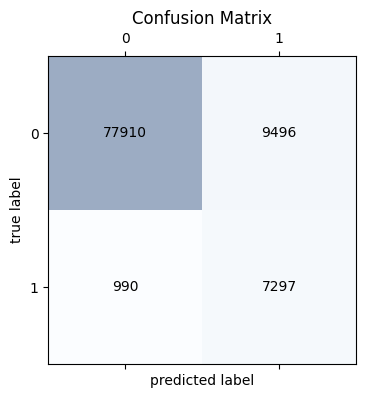

In [16]:
target = 'HeartDisease'
categorical_features, numerical_features = separate_cat_num_feat(df_train_clean, [target])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

numerical_transformer = Pipeline(steps=[
                                       ('scaler', StandardScaler())])

                                   
                                   
preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_features),
                  ("num", numerical_transformer, numerical_features)]
)

pipeline = Pipeline([
    ("feat_engineering_1", CatPhysicalActiv()),
    ("feat_engineering_2", CatHealthyLifestyle()),
    ("preprocessor", preprocessor),
    ('model', RandomForestClassifier(max_depth=6, random_state=42, n_jobs=-1))
])


X_train = df_train_clean.drop(columns=[target])
y_train = df_train_clean[target]

X_test = df_test_clean.drop(columns=[target])
y_test = df_test_clean[target]
print(X_train.shape[0])
print(y_train.shape[0])
#Performing oversampling (sampling_strategy coeff. chosen for scoring purposes)
ros_sampler = RandomOverSampler(sampling_strategy=0.5, random_state=42)
X_train, y_train = ros_sampler.fit_resample(X_train, y_train)
print(X_train.shape[0])
print(y_train.shape[0])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)


print('General')
print('ROCAUC score:{}'.format(roc_auc_score(y_test, y_pred)))
print('f1_score:{}'.format(f1_score(y_test, y_pred)))
print('precision:{}'.format(precision_score(y_test, y_pred)))
print('recall:{}\n'.format(recall_score(y_test, y_pred)))

confmat = confusion_matrix(y_true=y_test, 
                           y_pred=y_pred)
make_confmat_pretty(confmat)

### ROC-AUC Score

/tmp/ipykernel_400/2593556377.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'No' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.loc[X['Weekly PhysicalActivity (H)'] == 0, 'PhysicalActivity'] = 'No'


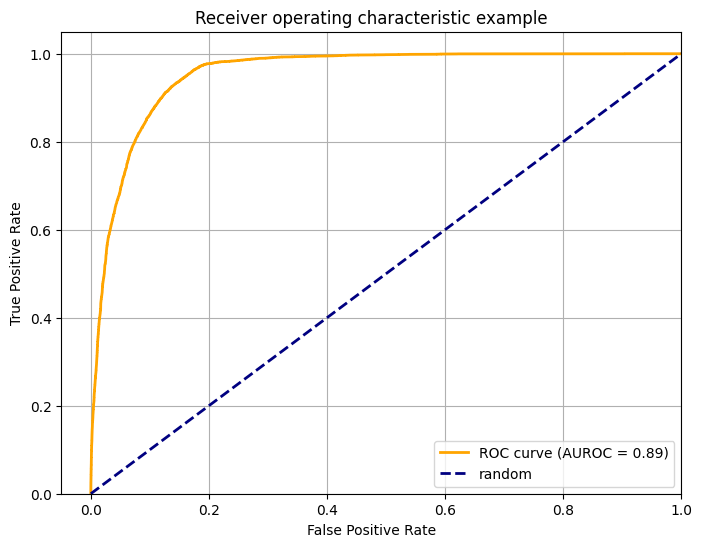

In [17]:
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_score=pipeline.predict_proba(X_test)[:,1], y_true=y_test)
def plot_roc_curve(roc_auc, fpr, tpr):
    
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
plot_roc_curve(roc_auc, fpr, tpr)

##### Load the test set

In [14]:
test = pd.read_csv('test.csv').set_index("id")

##### Use the pipeline to get predictions (very simple!)

In [ ]:
y_scores_final = pipeline.predict_proba(test)[:,1]

##### Prepare the submissions file

In [ ]:
submission = pd.Series(y_scores_final,index=test.index, name='order_id')
submission.to_csv("submission.csv")